# Strojenie modelu BERT-base na danych *cyberbullying*

## Biblioteki

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments,  DataCollatorWithPadding, pipeline, BertForMaskedLM
from sklearn.metrics import f1_score, confusion_matrix
from peft import PeftModel, LoraConfig, TaskType, get_peft_model
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import kagglehub
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset
import json
import os
import seaborn as sns
import random
import torch
import logging

In [2]:
torch.cuda.empty_cache()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}")

cuda


## Załadowanie danych - Teksty

In [4]:
FILE_NAME = "HateSpeechDataset.csv"
KAGGLE_DATASET  = "waalbannyantudre/hate-speech-detection-curated-dataset"

if not os.path.exists(FILE_NAME):
    print(f"Pobieranie datasetu {KAGGLE_DATASET} z Kaggle...")
    kagglehub.download_dataset(KAGGLE_DATASET, FILE_NAME)
    print("Pobieranie zakończone")
else:
    print(f"Dataset {FILE_NAME} już istnieje")

Dataset HateSpeechDataset.csv już istnieje


In [5]:
df = pd.read_csv('HateSpeechDataset.csv')
df['text'] = df['Content']
df = df.drop(columns=['Content_int', 'Content'])
df = df[df['Label'] != 'Label']
display(df.head())

,Label,text
0,1,denial of normal the con be asked to comment o...
1,1,just by being able to tweet this insufferable ...
2,1,that is retarded you too cute to be single tha...
3,1,thought of a real badass mongol style declarat...
4,1,afro american basho


In [6]:
# Podział zbioru na zbiór treningowy i testowy
texts_train, texts_test, text_labels_train, text_labels_test = train_test_split(
    df['text'], df['Label'], test_size=0.2, random_state=42
)

# Zmiana formatu danych na DataFrame
df_train = pd.DataFrame()
df_train['text'] = texts_train
df_train['LABEL'] = text_labels_train

df_test = pd.DataFrame()
df_test['text'] = texts_test
df_test['LABEL'] = text_labels_test

# Zbalansowanie zbioru treningowego i testowego
# min_class_count = df_train['LABEL'].value_counts().min()
min_class_count_train = 500
min_class_count_test = 250

df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_22972\2293288302.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_22972\2293288302.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.samp

In [48]:
# Zmiana formatu danych na JSON
train_json = df_train_balanced.to_json(orient='records')
test_json = df_test_balanced.to_json(orient='records')


train_dataset = Dataset.from_list(json.loads(train_json))
test_dataset = Dataset.from_list(json.loads(test_json))


dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(dataset['train'])
print(dataset['test'])

Dataset({
    features: ['text', 'LABEL'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'LABEL'],
    num_rows: 500
})


In [8]:
for entry in dataset['train'].select(range(5)):
    print('TEXT: {} \nLABEL: {}\n'.format(entry['text'], entry['LABEL']))

TEXT: oh sorry that what a slut vandalism i did not think so i thought it what a slut an improvement i will stay away from the article which articles i edit here 
LABEL: 0

TEXT: ban proposal i have proposed that you and several other accounts be banned from the english wikipedia at span proposed ban for lance user taken you can comment on the proposal there 
LABEL: 0

TEXT: i am tired off that piss poor excuse from conservatives which is pretty much synonymous with bigot nowadays it is not fear they feel it is shame the same shame all hypocrites feel 
LABEL: 0

TEXT: redirect talkkhwaza held swat 
LABEL: 0

TEXT: it is refreshing to see so many mixed race people in this area 
LABEL: 0



In [9]:
train_counts = pd.DataFrame({'Sentiment': dataset['train']['LABEL']})
train_counts = train_counts.groupby('Sentiment').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Sentiment': dataset['test']['LABEL']})
test_counts = test_counts.groupby('Sentiment').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Sentiment'))

,Sentiment,train_set,test_set
0,0,500,250
1,1,500,250


## Strojenie modelu dla zadania klasyfikacji tekstu

In [10]:
sorted_labels = sorted(set(dataset['train']['LABEL']))
label2id = dict(zip(sorted_labels, range(0, len(sorted_labels))))
id2label = dict(zip(range(0, len(sorted_labels)), sorted_labels))

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                    num_labels=len(label2id),
                                                                    label2id=label2id,
                                                                    id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['label'] = [label2id[l] for l in examples["LABEL"]]
    return tokens

splits = ['train', 'test']

tokenized_ds = {} 

for split in splits:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)

print(tokenized_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 500
})}


In [12]:
print("A tokenized training input example:")
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["label"])
print(tokenized_ds["train"][0]['attention_mask'])

A tokenized training input example:
[101, 2821, 3374, 2008, 2054, 1037, 22889, 4904, 3158, 9305, 2964, 1045, 2106, 2025, 2228, 2061, 1045, 2245, 2009, 2054, 1037, 22889, 4904, 2019, 7620, 1045, 2097, 2994, 2185, 2013, 1996, 3720, 2029, 4790, 1045, 10086, 2182, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()*100, "f1": f1_score(labels, predictions, labels=[0, 1], pos_label=1)}

#### PEFT-BERT

In [14]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=1, lora_dropout=0.1
)

model_pert = get_peft_model(model, lora_config)

In [15]:
trainer_pert = Trainer(
    model=model_pert,
    args=TrainingArguments(
        output_dir="bert-lora",
        learning_rate=2e-3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=8,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Starting to train...")
trainer_pert.train()

d:\Python\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_18340\1520901696.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pert = Trainer(


Starting to train...


  0%|          | 0/4000 [00:00<?, ?it/s]

d:\Python\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.8294, 'grad_norm': 0.001986447023227811, 'learning_rate': 0.00175, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.865161120891571, 'eval_accuracy': 79.60000000000001, 'eval_f1': 0.7976190476190477, 'eval_runtime': 18.7023, 'eval_samples_per_second': 26.735, 'eval_steps_per_second': 13.367, 'epoch': 1.0}
{'loss': 0.7351, 'grad_norm': 0.07529377192258835, 'learning_rate': 0.0015, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9885197877883911, 'eval_accuracy': 77.8, 'eval_f1': 0.8096054888507719, 'eval_runtime': 18.762, 'eval_samples_per_second': 26.65, 'eval_steps_per_second': 13.325, 'epoch': 2.0}
{'loss': 0.5372, 'grad_norm': 7.944591999053955, 'learning_rate': 0.00125, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.801530122756958, 'eval_accuracy': 78.4, 'eval_f1': 0.7682403433476395, 'eval_runtime': 18.8185, 'eval_samples_per_second': 26.57, 'eval_steps_per_second': 13.285, 'epoch': 3.0}
{'loss': 0.4323, 'grad_norm': 11.236715316772461, 'learning_rate': 0.001, 'epoch': 4.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9980890154838562, 'eval_accuracy': 79.0, 'eval_f1': 0.7817047817047817, 'eval_runtime': 18.9083, 'eval_samples_per_second': 26.443, 'eval_steps_per_second': 13.222, 'epoch': 4.0}
{'loss': 0.3152, 'grad_norm': 7.119736194610596, 'learning_rate': 0.00075, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.8868651986122131, 'eval_accuracy': 77.2, 'eval_f1': 0.7807692307692308, 'eval_runtime': 20.5504, 'eval_samples_per_second': 24.33, 'eval_steps_per_second': 12.165, 'epoch': 5.0}
{'loss': 0.2251, 'grad_norm': 1.8016250133514404, 'learning_rate': 0.0005, 'epoch': 6.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1103360652923584, 'eval_accuracy': 77.60000000000001, 'eval_f1': 0.776, 'eval_runtime': 20.568, 'eval_samples_per_second': 24.31, 'eval_steps_per_second': 12.155, 'epoch': 6.0}
{'loss': 0.1847, 'grad_norm': 1.5864635705947876, 'learning_rate': 0.00025, 'epoch': 7.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1517926454544067, 'eval_accuracy': 77.60000000000001, 'eval_f1': 0.7846153846153846, 'eval_runtime': 18.882, 'eval_samples_per_second': 26.48, 'eval_steps_per_second': 13.24, 'epoch': 7.0}
{'loss': 0.1207, 'grad_norm': 7.010550498962402, 'learning_rate': 0.0, 'epoch': 8.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.2937402725219727, 'eval_accuracy': 77.2, 'eval_f1': 0.7782101167315175, 'eval_runtime': 18.8995, 'eval_samples_per_second': 26.456, 'eval_steps_per_second': 13.228, 'epoch': 8.0}
{'train_runtime': 901.908, 'train_samples_per_second': 8.87, 'train_steps_per_second': 4.435, 'train_loss': 0.4224689311981201, 'epoch': 8.0}


TrainOutput(global_step=4000, training_loss=0.4224689311981201, metrics={'train_runtime': 901.908, 'train_samples_per_second': 8.87, 'train_steps_per_second': 4.435, 'total_flos': 2112173998080000.0, 'train_loss': 0.4224689311981201, 'epoch': 8.0})

In [16]:
model_path_pert = 'pert_model-weights/'
model_pert.save_pretrained(model_path_pert)

## Ocena jakości predyckji

In [16]:
model_path_pert = 'pert_model-weights/'
model_pert = PeftModel.from_pretrained(model, model_path_pert)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

trainer_pert = Trainer(
    model=model,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

In [17]:
predictions_pert = trainer_pert.predict(tokenized_ds['test'])

predicted_labels_pert = predictions_pert.predictions.argmax(axis=1)  
true_labels_pert = predictions_pert.label_ids 
metrics_pert = predictions_pert.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics_pert.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")

d:\Python\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/63 [00:00<?, ?it/s]

Wyniki:
--------------------
Test Loss: 0.8853
Test Model Preparation Time: 0.0048
Test Accuracy: 74.8000
Test F1: 0.7364
Test Runtime: 17.4203
Test Samples Per Second: 28.7020
Test Steps Per Second: 3.6160


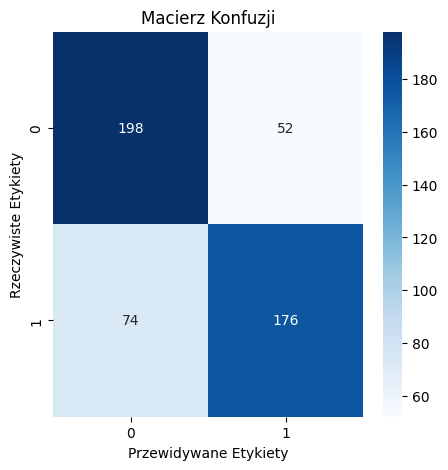

In [18]:
conf_matrix = confusion_matrix(true_labels_pert, predicted_labels_pert)

labels = np.unique(true_labels_pert)  
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()

## Wizualizacja przestrzeni wektorowej

### Embeddings

In [19]:
def embed_text(examples):
    inputs = tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

    with torch.no_grad():
        model_pert.to('cpu')
        outputs = model_pert(**inputs, output_hidden_states=True)
    token_embeddings = outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()
    return token_embeddings

def wrap_text(text, width=40):
    return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])


In [20]:
text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])
text['text'] = text['text'].apply(wrap_text)

embeddings = embed_text(dataset['test'])

#### PCA

In [21]:
pca = PCA(n_components=2).fit_transform(embeddings)

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels_pert[i] for i in range(len(predicted_labels_pert))]
df_pca['Text'] = text['text']
df_pca['True label'] = [true_labels_pert[i] for i in range(len(true_labels_pert))]

fig = px.scatter(df_pca, x="PCA1", y="PCA2", color="Predicted Label", hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych - PCA",
                labels={"PC1": "Pierwsza składowa główna", "PC2": "Druga składowa główna"})
fig.show()

#### TSNE

In [22]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels_pert[i] for i in range(len(predicted_labels_pert))]
df_tsne['Text'] = text['text']
df_tsne['True label'] = [true_labels_pert[i] for i in range(len(true_labels_pert))]

fig = px.scatter(df_tsne, x='x', y='y', color='Predicted Label', hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych - T-SNE")
fig.show()

## [MASK] - powiększanie zbioru

In [32]:
def mask_word(text, mask_token='[MASK]'):
    words = text.split()
    masked_idx = [i for i, word in enumerate(words) if word.isalpha()]
    
    if not masked_idx:
        return text, -1

    masked_word = random.choice(masked_idx)
    words[masked_word] = mask_token
    return ' '.join(words), masked_word

In [33]:
def augument_sentence(text, n=3):
    masked_text, mask_index = mask_word(text)
    
    if mask_index == -1:
        print("No words to mask")
        return text
    
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    
    model_name = "bert-base-uncased"
    tokenizer_mask = BertTokenizer.from_pretrained(model_name)
    model_mask = BertForMaskedLM.from_pretrained(model_name)
    
    fill_mask = pipeline("fill-mask", model=model_mask, tokenizer=tokenizer_mask, device=device)
    
    predictions = fill_mask(masked_text)
    
    augmented_sentences = []
    for i, prediction in enumerate(predictions[:n]):
        predicted_word = prediction['token_str']
        words = masked_text.split()
        words[mask_index] = predicted_word
        new_sentence = ' '.join(words)
        augmented_sentences.append(new_sentence)
        
    return augmented_sentences
    

In [34]:
def augument_dataset(dataset, n=3):
    augumented_texts = []
    augumented_labels = []
    
    for i, example in enumerate(dataset):
        text = example['text']
        label = example['LABEL']
        
        augumented_sentence= augument_sentence(text, n)
        augumented_texts.extend(augumented_sentence)
        augumented_labels.extend([label] * n)
        
        if i%100 == 0:
            print("="*50)
            print(f'Oryginalne zdanie: {text}')
            for j, sentence in enumerate(augumented_sentence):
                print(f'Zaugumentowane zdanie {j+1}: {sentence}')
            print("\n")
        
    augumented_dataset = Dataset.from_dict({'text': augumented_texts, 'LABEL': augumented_labels})
    
    return concatenate_datasets([dataset, augumented_dataset])

In [35]:
augument_train = augument_dataset(dataset['train'], n=3)

print("Orginal train dataset size:", len(dataset['train']))
print("Augumented train dataset size:", len(augument_train))

Oryginalne zdanie: oh sorry that what a slut vandalism i did not think so i thought it what a slut an improvement i will stay away from the article which articles i edit here
Zaugumentowane zdanie 1: oh sorry that what a slut vandalism i did not think so i thought it what a slut an improvement i will take away from the article which articles i edit here
Zaugumentowane zdanie 2: oh sorry that what a slut vandalism i did not think so i thought it what a slut an improvement i will keep away from the article which articles i edit here
Zaugumentowane zdanie 3: oh sorry that what a slut vandalism i did not think so i thought it what a slut an improvement i will go away from the article which articles i edit here


Oryginalne zdanie: i will stick with the wine yet try to adapt to some semblance of moderation but damn that is a tough goal ha
Zaugumentowane zdanie 1: i will stick with the plan yet try to adapt to some semblance of moderation but damn that is a tough goal ha
Zaugumentowane zdani

In [36]:
dataset['train'] = augument_train

In [39]:
augument_train.to_json("augmented_dataset.json", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

861130

## Strojenie modelu dla powiększonego zbioru danych

In [40]:
data_train = load_dataset("json", data_files="augmented_dataset.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [51]:
train_dataset = Dataset.from_list(data_train['train'])
test_dataset = Dataset.from_list(json.loads(test_json))


dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [53]:
splits = ['train', 'test']

tokenized_ds = {} 

for split in splits:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)

print(tokenized_ds)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 4000
}), 'test': Dataset({
    features: ['text', 'LABEL', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 500
})}


In [54]:
model_pert = PeftModel.from_pretrained(model, model_path_pert)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

trainer_augumented_data = Trainer(
    model=model_pert,
    args=TrainingArguments(
        output_dir="bert-lora",
        learning_rate=2e-3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=8,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Starting to train...")
trainer_augumented_data.train()

d:\Python\Lib\site-packages\transformers\training_args.py:1559: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

C:\Users\DELL\AppData\Local\Temp\ipykernel_22972\3172000056.py:4: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Starting to train...


  0%|          | 0/16000 [00:00<?, ?it/s]

{'loss': 0.8427, 'grad_norm': 0.5663530230522156, 'learning_rate': 0.0019375, 'epoch': 0.25}
{'loss': 0.7787, 'grad_norm': 0.18448784947395325, 'learning_rate': 0.001875, 'epoch': 0.5}
{'loss': 0.6926, 'grad_norm': 0.33249109983444214, 'learning_rate': 0.0018125, 'epoch': 0.75}
{'loss': 0.7321, 'grad_norm': 3.1281449794769287, 'learning_rate': 0.00175, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.5737740993499756, 'eval_accuracy': 77.0, 'eval_f1': 0.7758284600389863, 'eval_runtime': 18.8431, 'eval_samples_per_second': 26.535, 'eval_steps_per_second': 13.267, 'epoch': 1.0}
{'loss': 0.6807, 'grad_norm': 7.139552116394043, 'learning_rate': 0.0016875, 'epoch': 1.25}
{'loss': 0.6513, 'grad_norm': 0.931623101234436, 'learning_rate': 0.0016250000000000001, 'epoch': 1.5}
{'loss': 0.6797, 'grad_norm': 1.5512592792510986, 'learning_rate': 0.0015625, 'epoch': 1.75}
{'loss': 0.7012, 'grad_norm': 0.06521768122911453, 'learning_rate': 0.0015, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.7473189830780029, 'eval_accuracy': 79.0, 'eval_f1': 0.8073394495412844, 'eval_runtime': 19.0239, 'eval_samples_per_second': 26.283, 'eval_steps_per_second': 13.141, 'epoch': 2.0}
{'loss': 0.6567, 'grad_norm': 10.650982856750488, 'learning_rate': 0.0014375, 'epoch': 2.25}
{'loss': 0.6872, 'grad_norm': 3.034512758255005, 'learning_rate': 0.001375, 'epoch': 2.5}
{'loss': 0.5947, 'grad_norm': 0.5186392068862915, 'learning_rate': 0.0013125, 'epoch': 2.75}
{'loss': 0.6664, 'grad_norm': 15.699996948242188, 'learning_rate': 0.00125, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6543647646903992, 'eval_accuracy': 76.8, 'eval_f1': 0.7734375, 'eval_runtime': 19.1475, 'eval_samples_per_second': 26.113, 'eval_steps_per_second': 13.057, 'epoch': 3.0}
{'loss': 0.6197, 'grad_norm': 7.6578803062438965, 'learning_rate': 0.0011875, 'epoch': 3.25}
{'loss': 0.6499, 'grad_norm': 8.03206729888916, 'learning_rate': 0.0011250000000000001, 'epoch': 3.5}
{'loss': 0.636, 'grad_norm': 2.547696113586426, 'learning_rate': 0.0010625, 'epoch': 3.75}
{'loss': 0.6668, 'grad_norm': 7.6806721687316895, 'learning_rate': 0.001, 'epoch': 4.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6854150295257568, 'eval_accuracy': 76.8, 'eval_f1': 0.7716535433070866, 'eval_runtime': 19.186, 'eval_samples_per_second': 26.061, 'eval_steps_per_second': 13.03, 'epoch': 4.0}
{'loss': 0.609, 'grad_norm': 7.957456588745117, 'learning_rate': 0.0009375, 'epoch': 4.25}
{'loss': 0.6041, 'grad_norm': 12.83027458190918, 'learning_rate': 0.000875, 'epoch': 4.5}
{'loss': 0.6541, 'grad_norm': 7.306509494781494, 'learning_rate': 0.0008125000000000001, 'epoch': 4.75}
{'loss': 0.6271, 'grad_norm': 7.196167469024658, 'learning_rate': 0.00075, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6326426863670349, 'eval_accuracy': 77.60000000000001, 'eval_f1': 0.78125, 'eval_runtime': 19.172, 'eval_samples_per_second': 26.08, 'eval_steps_per_second': 13.04, 'epoch': 5.0}
{'loss': 0.6221, 'grad_norm': 0.774118959903717, 'learning_rate': 0.0006875, 'epoch': 5.25}
{'loss': 0.6002, 'grad_norm': 11.552017211914062, 'learning_rate': 0.000625, 'epoch': 5.5}
{'loss': 0.6245, 'grad_norm': 0.08919104188680649, 'learning_rate': 0.0005625000000000001, 'epoch': 5.75}
{'loss': 0.559, 'grad_norm': 9.372227668762207, 'learning_rate': 0.0005, 'epoch': 6.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6298790574073792, 'eval_accuracy': 77.2, 'eval_f1': 0.7816091954022989, 'eval_runtime': 19.1478, 'eval_samples_per_second': 26.113, 'eval_steps_per_second': 13.056, 'epoch': 6.0}
{'loss': 0.5818, 'grad_norm': 0.5843635201454163, 'learning_rate': 0.0004375, 'epoch': 6.25}
{'loss': 0.6119, 'grad_norm': 1.7905508279800415, 'learning_rate': 0.000375, 'epoch': 6.5}
{'loss': 0.6143, 'grad_norm': 1.8362483978271484, 'learning_rate': 0.0003125, 'epoch': 6.75}
{'loss': 0.566, 'grad_norm': 8.490909576416016, 'learning_rate': 0.00025, 'epoch': 7.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6783268451690674, 'eval_accuracy': 78.4, 'eval_f1': 0.797752808988764, 'eval_runtime': 19.0936, 'eval_samples_per_second': 26.187, 'eval_steps_per_second': 13.093, 'epoch': 7.0}
{'loss': 0.5901, 'grad_norm': 8.095770835876465, 'learning_rate': 0.0001875, 'epoch': 7.25}
{'loss': 0.6597, 'grad_norm': 4.466259002685547, 'learning_rate': 0.000125, 'epoch': 7.5}
{'loss': 0.5305, 'grad_norm': 4.019985198974609, 'learning_rate': 6.25e-05, 'epoch': 7.75}
{'loss': 0.5194, 'grad_norm': 11.176736831665039, 'learning_rate': 0.0, 'epoch': 8.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6359022855758667, 'eval_accuracy': 78.60000000000001, 'eval_f1': 0.799249530956848, 'eval_runtime': 19.0571, 'eval_samples_per_second': 26.237, 'eval_steps_per_second': 13.118, 'epoch': 8.0}
{'train_runtime': 1523.6468, 'train_samples_per_second': 21.002, 'train_steps_per_second': 10.501, 'train_loss': 0.6409451847076416, 'epoch': 8.0}


TrainOutput(global_step=16000, training_loss=0.6409451847076416, metrics={'train_runtime': 1523.6468, 'train_samples_per_second': 21.002, 'train_steps_per_second': 10.501, 'total_flos': 8448695992320000.0, 'train_loss': 0.6409451847076416, 'epoch': 8.0})

In [55]:
model_path_mask = 'pert_model_mask-weights/'
model_pert.save_pretrained(model_path_mask)

### Ocena jakości predykcji [MASK]

In [56]:
model_mask = PeftModel.from_pretrained(model, model_path_mask)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

trainer_augumented_data = Trainer(
    model=model_mask,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

In [57]:
predictions_mask = trainer_augumented_data.predict(tokenized_ds['test'])

predicted_labels_mask = predictions_mask.predictions.argmax(axis=1)  
true_labels_mask = predictions_mask.label_ids 
metrics_mask = predictions_mask.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics_mask.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")

  0%|          | 0/63 [00:00<?, ?it/s]

Wyniki:
--------------------
Test Loss: 0.5738
Test Model Preparation Time: 0.0042
Test Accuracy: 77.0000
Test F1: 0.7758
Test Runtime: 17.3183
Test Samples Per Second: 28.8710
Test Steps Per Second: 3.6380


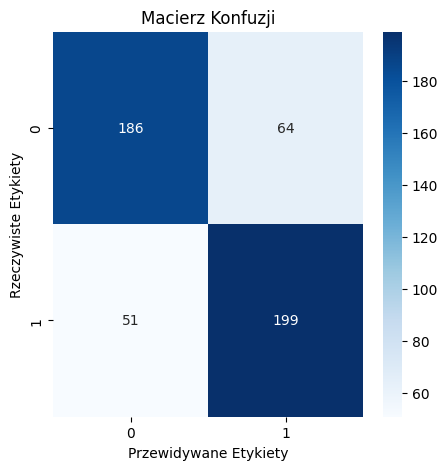

In [58]:
conf_matrix = confusion_matrix(true_labels_mask, predicted_labels_mask)

labels = np.unique(true_labels_mask)  
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()

### Wizualizacja przestrzeni wektorowej [MASK]

In [59]:
text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])
text['text'] = text['text'].apply(wrap_text)

embeddings = embed_text(dataset['test'])

#### PCA

In [60]:
pca = PCA(n_components=2).fit_transform(embeddings)

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels_mask[i] for i in range(len(predicted_labels_mask))]
df_pca['Text'] = text['text']
df_pca['True label'] = [true_labels_mask[i] for i in range(len(true_labels_mask))]

fig = px.scatter(df_pca, x="PCA1", y="PCA2", color="Predicted Label", hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych",
                labels={"PC1": "Pierwsza składowa główna", "PC2": "Druga składowa główna"})
fig.show()

#### T-SNE

In [61]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels_mask[i] for i in range(len(predicted_labels_mask))]
df_tsne['Text'] = text['text']
df_tsne['True label'] = [true_labels_mask[i] for i in range(len(true_labels_mask))]

fig = px.scatter(df_tsne, x='x', y='y', color='Predicted Label', hover_data={'Text': True, 'True label': True}, title="Wizualizacja przestrzeni wektorowej prób testowych")
fig.show()

In [1]:
print()